# Multivariate Analysis - PCA

In this notebook we will perform an unsupervised *multivariate* exploratory analysis with principal component analysis (PCA). 

The notebook is divided in the following steps:

1) Model fitting basics: Fit PCA models to the dataset with different scaling options.

2) Model Cross-validation and component selection: Describe model cross-validation routines, and best practices for model performance benchmarking and parameter selection. 

3) Outlier detection and model interpretation: Use PCA to explore the main trends in the dataset and detect potential outliers.


## Code import

Import all the packages and configure notebook plotting mode.

In [3]:
# Import the required python packages including 
# the custom Chemometric Model objects
import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt

from pyChemometrics.ChemometricsPCA import ChemometricsPCA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler
from pyChemometrics.plotting_utils import plotLoadings
from pyChemometrics.plotting_utils import _scatterplots


# Use to obtain same values as in the text
np.random.seed(350)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [2]:
# Set the plot backend to support interactive plotting
# %matplotlib notebook

## Data import

We will now import the LC-MS data with the metadata (Y variables) and feature annotation for LC-MS.

Then we split the metadata into two parts: 

X - LC-MS data matrix

gender_y - Metadata that will act as the response variable for the PLS-DA model (sex/gender in this instance)

retention_times, mz_values - annotation for the features of the rpos_x_matrix data 

#### Metadata
Y - represents the sex of the indivitudals (0: Female, 1: Male) used as the response variable for the PLS-DA model

##### NB - Full data available from: [https://zenodo.org/doi/10.5281/zenodo.4053166](https://zenodo.org/doi/10.5281/zenodo.4053166).

In [4]:
# Load the dataset
dementia_rpos_dataset = pd.read_csv("./data/Dementia U RPOS_combinedData.csv",delimiter=',')

# Delete samples where outcome variable is unknown (In this example QC samples)
dementia_rpos_dataset = dementia_rpos_dataset[~dementia_rpos_dataset['Gender'].isnull()]

X = dementia_rpos_dataset.iloc[:, 5::].values

variable_names = dementia_rpos_dataset.columns[5::]

# Use pandas Categorical type
Y = pd.Categorical(dementia_rpos_dataset['Gender']).codes
Y2 = dementia_rpos_dataset['Age'].values

# Extract the retention times and m/z to use in 2D plots of the dataset
retention_times = np.array([x.split('_')[0] for x in variable_names], dtype='float')/60
mz_values = np.array([x.split('_')[1][0:-3] for x in variable_names], dtype='float')

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pd.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pd.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 

Plot the Retention Times to mass-to-charge ratio of the dataset.


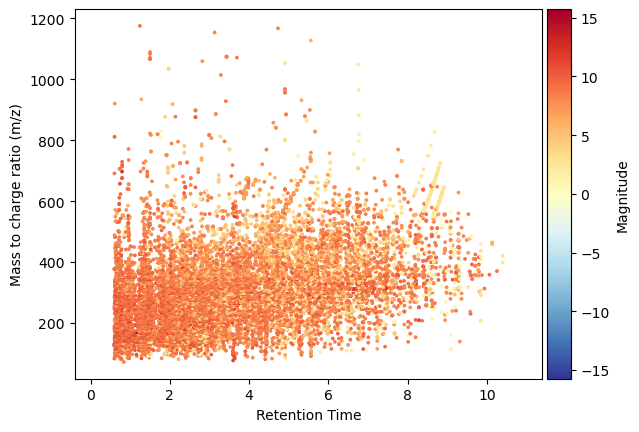

In [8]:
_scatterplots(np.log1p(X).mean(axis=0), xaxis=retention_times, yaxis=mz_values, marker_size=3, alpha=1)

# Exploratory Unsupervised analysis using PCA

In this tutorial we will fit a PCA model to explore the general trends in the dataset and assess if there are any potential outliers (cause by instrumental issues during data acquisition, for example). We start by describing the model syntax for fitting the PCA models.

## 1) PCA model fitting and scaling

### Scaling options and preliminary model fitting

We will start by calculating a series of PCA models with 2 components, each with one of the 3 common scaling choices in chemometrics - mean centring (MC), Unit Variance (UV) and Pareto (Par) scaling. The choice of components to use in the modeling will be addressed properly in the next section.

In [5]:
# Select the scaling options: 
# Here we are generating 3 scaling objects to explore the effect of scaling in PCA:

# Unit-Variance (UV) scaling:
scaling_object_uv = ChemometricsScaler(scale_power=1)

# Mean Centering (MC):
scaling_object_mc = ChemometricsScaler(scale_power=0)

# Pareto scaling (Par):
scaling_object_par = ChemometricsScaler(scale_power=0.5)

The scaling object will store the vector of column means and standard deviations as it was estimated from the dataset passed to the *fit* method (i.e., during "training" of the classifier).

Pass each scaling object to the PCA method.

In [6]:
# Create and fit the PCA model - starting with UV
PCA_model_uv = ChemometricsPCA(ncomps=2, scaler=scaling_object_uv)
PCA_model_uv.fit(X)

In [7]:
# Create and fit the PCA model - MC
PCA_model_mc = ChemometricsPCA(ncomps=2, scaler=scaling_object_mc)
PCA_model_mc.fit(X)

In [8]:
# Create and fit the PCA model - Par
PCA_model_par = ChemometricsPCA(ncomps=2, scaler=scaling_object_par)
PCA_model_par.fit(X)

### Effect of scaling on PCA Score plots

These plots show the effect that different scaling parameters have on the PCA scores. The scores plots are a usefull summary of the multivariate similarity between samples, and will be used to inspect the main trends in the data. 

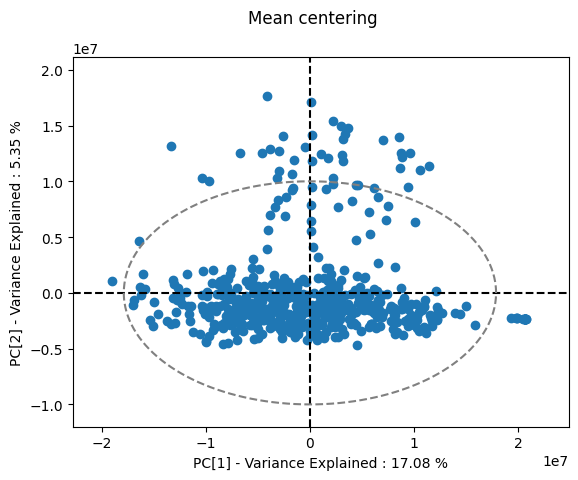

<Axes: xlabel='PC[1] - Variance Explained : 17.08 %', ylabel='PC[2] - Variance Explained : 5.35 %'>

In [9]:
# PCA score plot for the mean centered model
PCA_model_mc.plot_scores(comps=[0, 1], plot_title='Mean centering')


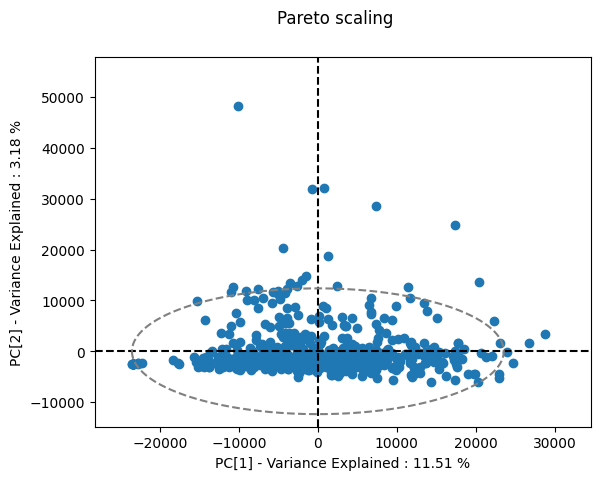

<Axes: xlabel='PC[1] - Variance Explained : 11.51 %', ylabel='PC[2] - Variance Explained : 3.18 %'>

In [10]:
# Score plot for the Pareto scaled model
PCA_model_par.plot_scores(comps=[0, 1], plot_title='Pareto scaling')


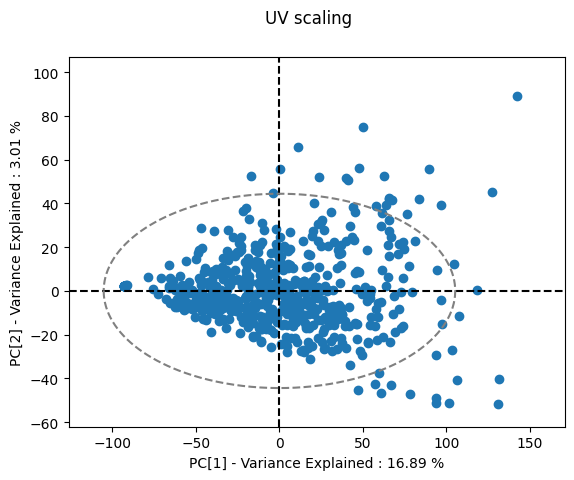

<Axes: xlabel='PC[1] - Variance Explained : 16.89 %', ylabel='PC[2] - Variance Explained : 3.01 %'>

In [11]:
# PCA score plot for UV scaled model
PCA_model_uv.plot_scores(comps=[0, 1], plot_title='UV scaling')


### Effect of scaling on PCA loadings

These plots show the effect that different scaling parameters have on the PCA loadings (also designated as $p$, when refering to a single loading vector or $P$ to the matrix containing the loading vectors for all components). 

Although different types of scaling can be used to investigate the structure of the dataset, each type of scaling results in different models, potentially with different interpretations. The *plot_scores* function automatically draws a 95% confidence Hotelling $T^{2}$ ellipse, and flags the points as potential outliers.

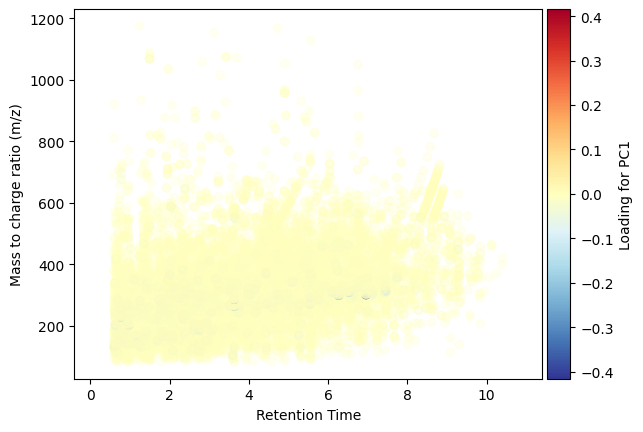

In [12]:
# Plot of first principal component loadings of mean centering model
# ax = PCA_model_mc.plot_loadings(component=1)
PCA_model_mc.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms')

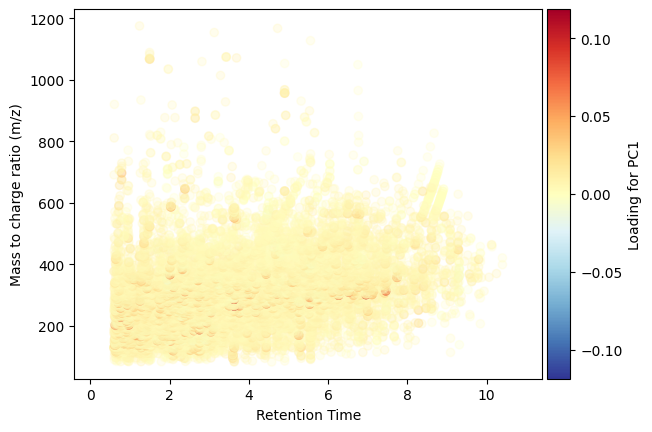

In [13]:
# Plot of first principal component loadings of Pareto scaled model
# ax = PCA_model_par.plot_loadings(component=1)
PCA_model_par.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms')

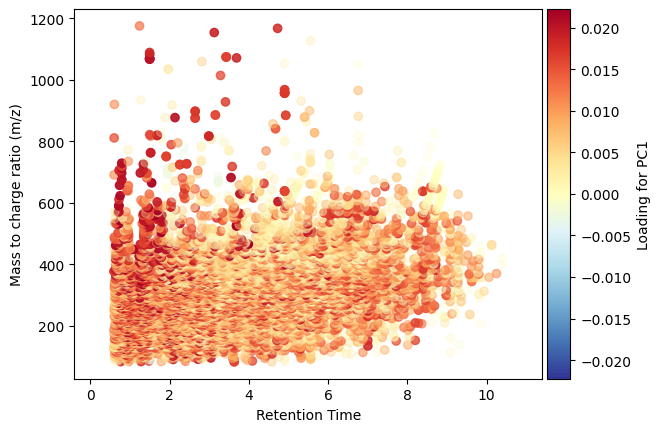

In [14]:
# Plot of first principal component loadings of Unit Variance scaled model
# ax = PCA_model_uv.plot_loadings(component=1)
PCA_model_uv.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms')

This example highlights the effects of different scaling approaches on PCA scores, loadings, their interpretation and the structure recovered by the model.

We will now proceed with the exploratory analysis of this dataset using UV scaling.

Direct plots of the loading vectors can be hard to interpret, especially when using UV scaling. A better way to visualize these quantities is to overlay them on a representative spectrum (e.g. median spectrum) with a colourscale. 

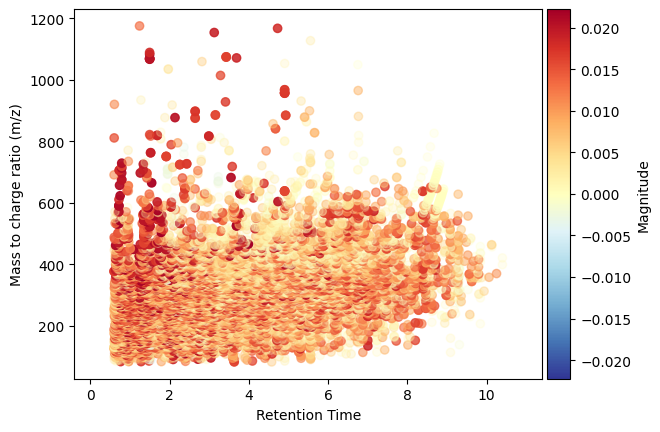

In [15]:
## NB needs to be re-written for LC-MS data - DONE IT

# Plot of first principal component loadings overlaid on the median spectrum - UV
# plotLoadings(PCA_model_uv.loadings[0, :], ppm, spectra=X)

_scatterplots(PCA_model_uv.loadings[0, :], xaxis=retention_times, yaxis=mz_values)

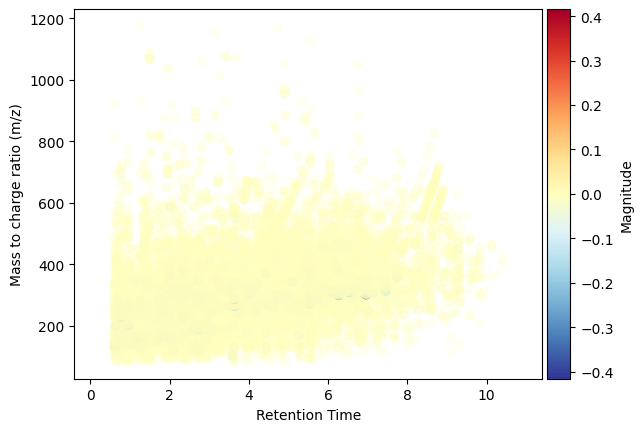

In [16]:
## NB needs to be re-written for LC-MS data - DONE IT

# Plot of first principal component loadings overlaid on the median spectrum - Mean centring
# plotLoadings(PCA_model_mc.loadings[0, :], ppm, spectra=X)

_scatterplots(PCA_model_mc.loadings[0, :], xaxis=retention_times, yaxis=mz_values)


## 2) Model cross-validation and component selection

When generating a PCA model, the number of components is the main parameter that must be chosen.

Ideally, we want to select enough components to capture as much structured variation in the data as possible, but not so  many that random noise starts to be also incorporated in the PCA model.

A sugestion to select the number of components is to use the $Q^{2}X$ measure, and pick the number of components after this metric reaches a plateau (e.g. less than 5% increase compared to previous number of components). 

Q2X measure stabilizes (increase of less than 5% of previous value or decrease) at component 1


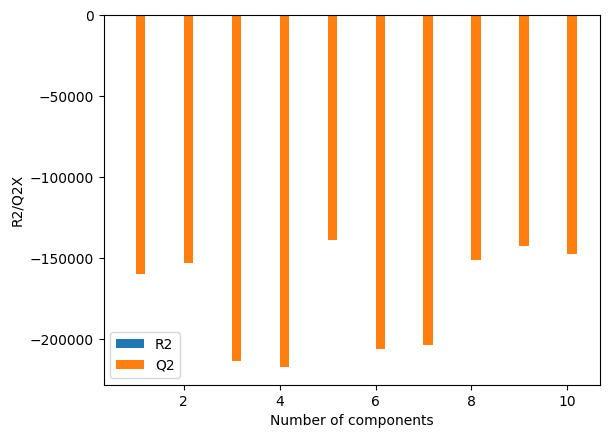

In [17]:
PCA_model_uv.scree_plot(X, total_comps=10)

Q2X measure stabilizes (increase of less than 5% of previous value or decrease) at component 2


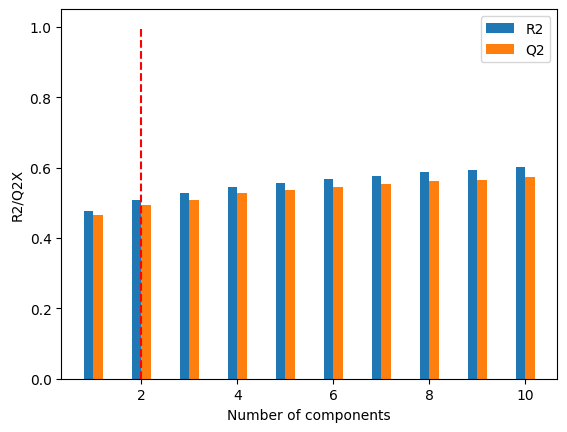

In [18]:
# The log data seems to work better for PCA too... It might be good to apply at the beginning
X_log = np.log1p(X)
PCA_model_uv.scree_plot(X_log, total_comps=10)

This suggestion should suffice for exploratory data analysis with PCA. However, the $Q^{2}X$ measure obtained for K-Fold cross validation is sensitive to row permutation of the X matrix. A more robust alternative is to use repeated cross-validation, shuffle the rows in the X matrix each time, and see the distribution of $Q^{2}X$ values per component. This should give a more comprehensive overview of each component's robustness.

**Note**: In an exploratory PCA analysis, the selection of the number of components is not as critical as in a PLS-DA model, and the user can simply select a set of components to explore the data and interactively adjust. Nevertheless, its still important to benchmark the cross-validated performance of the model, to avoid interpreting or infering biological conclusions from non-robust principal components.

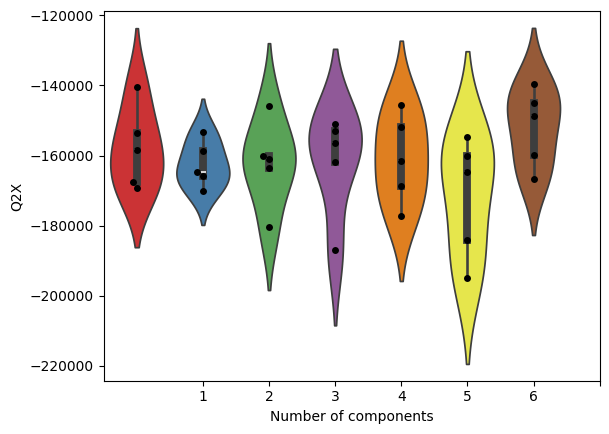

In [19]:
rep_cv = PCA_model_uv.repeated_cv(X, repeats=5)

Refit the model for further exploration with the selected number of components.

In [20]:
# Create and fit the PCA model - UV scaling
PCA_model_uv = ChemometricsPCA(ncomps=4, scaler=scaling_object_uv)
PCA_model_uv.fit(X)
PCA_model_uv.cross_validation(X)

If the *cross_validation* method has been called before for a PCA model object, the plot_loadings method will also show the estimated confidence bands (in light red) for the loading parameters. These were estimated during the cross validation procedure. The default value of $sigma = 2$ means that the plot uses the average $\pm2\sigma$ to draw the confidence bands.

In [ ]:
# I haven't figured it out how to perform a good plot for LC-MS, so we might just remove this bit?
PCA_model_uv.plot_loadings(component=1, sigma=2)

## 3) Outlier detection and model interpretation

### Outlier detection

PCA can be used to detect potential outliers, and screen samples where a potential problems might have occurred during data acquisition. The main outlier detection tool is the Hotelling $T^{2}$ statistic, a multivariate generalization of the Student's t-distribution. The *plot_scores* function automatically draws a 95% confidence ellipse for $T^{2}$ in the score plot. Samples outside the ellipse are candidate outliers and warrant further investigation.

**Note**: Bear in mind that outlier exclusion can affect the model performance, and therefore every outlier removed during analysis should be justified and always recorded.


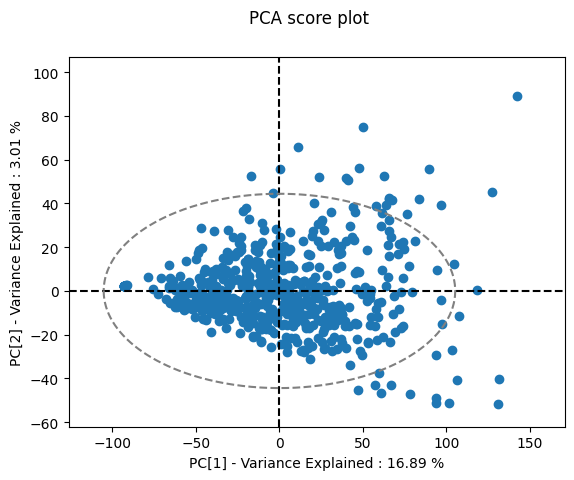

<Axes: xlabel='PC[1] - Variance Explained : 16.89 %', ylabel='PC[2] - Variance Explained : 3.01 %'>

In [21]:
PCA_model_uv.plot_scores(comps=[0, 1])

The PCA score plot highlighted a set of candidate outliers, but using only the 2 principal components plotted instead of the full model with 4 components. There is a cluster of 5 outliers in component 1 and 2. 

The *.outlier* function can be used to automatically obtain the indices for candidate outlying samples using all or only a set of selected components. This synthax can be used to obtain outliers matching any given visualization or alongside a single PC component, or to obtain an assessment of which samples are potential outliers using the whole model.

If using Hotelling T2, the significance level can be adjusted to control for the proportion of false positives in outlier detection. 

In [22]:
outlier_idx = PCA_model_uv.outlier(X)
print("Outliers for the full 4 component model : {0}".format(outlier_idx))
outlier_idx = PCA_model_uv.outlier(X, comps=[1])
print("Outliers for the 2nd principal component : {0}".format(outlier_idx))

Outliers for the full 4 component model : [  2   9  46  55  85 106 112 122 126 149 151 158 161 183 186 192 196 200
 203 214 215 236 241 269 317 325 341 355 368 370 372 410 431 444 449 453
 454 456 478 487 493 494 498 500 505 518 525 526]
Outliers for the 2nd principal component : [  2   4   9  46  61  82 106 111 112 122 126 127 133 136 158 161 179 192
 200 203 214 230 325 341 355 368 379 440 442 453 487 493 500 505 518 525
 526 563 576]


The next step is to identify the reason for the outlying scores. This can be done by 
inspection of the raw data (or a subset of it), analysis of the loading vectors, and by comparing the model predictions/data reconstruction performed by the model. One of the outliers has a very large peak close to 3.3 ppm.

In [ ]:
# plot the mean spectrum calculated from the raw data (blue) and the outlying spectra (red)
plt.figure()
plt.plot( X[outlier_idx, :].T, 'r')
plt.plot( np.mean(X, axis=0), 'b')
plt.gca()

# plt.show()

The PCA score plot should be interpreted using the loading vectors for the corresponding components.

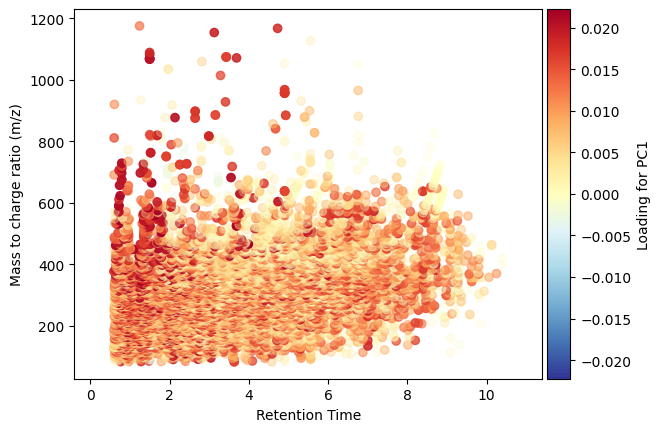

In [23]:
# ax = PCA_model_uv.plot_loadings(component=1)
PCA_model_uv.plot_loadings(ncomp=1,xaxis=retention_times, yaxis=mz_values,instrument='lcms')

Direct inspection of the loadings plot obtained from the UV scaled model is not very straightforward...

Another way to investigate outliers is to use score values (from actual samples or artificially created) to generate reconstructed spectra. We can explore the PCA model space in this way, and compare spectra representative of any desired region of the score plot. 
We backtransform the reconstructed samples obtained to the original dataspace (reverse the scaling and mean centering) for plotting and comparison.

<Figure size 640x480 with 0 Axes>

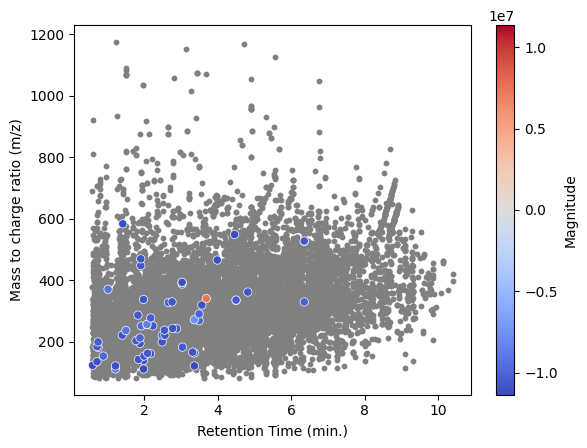

In [24]:
# Show the main features, and if an outlier exhibits a value markedly higher than the raw data (depicted in grey),
# it is visualized in accordance with the colorbar
PCA_model_uv.plot_outliers(X, outlier_idx, instrument='lcms', xaxis=retention_times, yaxis=mz_values)

The outlier samples have a baseline distortion next to the water peak region (4.6-6 $\delta_{H}$), potentially caused by bad phasing of the NMR spectrum during data pre-processing. We will remove these in future analyses.

Another useful measure for outlier detection is the DmodX (Distance to model X) measure. It is calculated based on the model residuals, and can be used to screen for samples which are poorly modelled by the PCA model. 
A DmodX plot shows the DmodX value for each sample. Higher values mean more unexplained variation (residual) for that particular sample. An exclusion criterion is delineated by using the F-statistic to discern if each sample seems to have a higher amount of unexplained variation than overall in the population of samples modelled.

The DmodX outliers are more useful to decide wether or not a sample should is overall well "explained" by the model. In this case we have quite a few samples above the critical line, but only 4 which seem to be strongly outlying in DmodX.

It is expected that in a variable biological population many observations will contain features not incorporated in a multivariate model fitted on the entire dataset. Adding more principal components could in theory add the residual variability not modelled which is responsible for the DmodX values. In this particular instance we do not take any decision based on the DmodX metric.

In [ ]:
# The DmodX plot 
PCA_model_uv.plot_dmodx(X, label_outliers=True)

In [ ]:
# The outlier function can also be used to obtain the DmodX measure and outliers detected with it
outlier_idx = PCA_model_uv.outlier(X, measure='DmodX', alpha=0.05)
print(outlier_idx)

## Model interpretation

We now refit the model without the outliers, and re-assess the findings. The *outlier* method returns the indexes of outlying obersavtions. In the next cell we call it with the *comps* argument = [1], to estimate outliers in the 2nd Principal Component.


In [ ]:
outlier_idx = PCA_model_uv.outlier(X, comps=[1])

print("The following samples (row index) have been detected as outliers: {0}".format(outlier_idx))
#Delete the outlier observations (rows)
X_rem = np.delete(X, outlier_idx, axis=0)
Y1_rem = np.delete(Y, outlier_idx, axis=0)
Y2_rem = np.delete(Y2, outlier_idx, axis=0)

After removing outliers, it is recommened to re-assess the model performance using cross validation, and to check whether a model with the same number of components as chosen before is still reliable.

In [ ]:
# Create and fit the PCA model - UV scaling
PCA_model_uv = ChemometricsPCA(ncomps=7, scaler=scaling_object_uv)
PCA_model_uv.fit(X_rem)
PCA_model_uv.scree_plot(X_rem, total_comps=10)

In [ ]:
rep_cv = PCA_model_uv.repeated_cv(X_rem, repeats=5, total_comps=10)

In [ ]:
PCA_model_uv.cross_validation(X_rem)
print("The estimated Q2X from the model is {0}".format(PCA_model_uv.cvParameters['Q2']))

Applying similar criteria as before, we now refit a PCA model with a total of 7 components. 

In [ ]:
PCA_model_uv.plot_scores()

**Note**: Excluding outliers and re-fitting the model can uncover new candidate outliers. It is not the purpose of this exploratory analysis to obtain a completely *outlier* free dataset for subsequent modelling. We recommend using PCA to screen mainly for large outliers associated with the main Principal components (those who explain a large proportion of the dataset variance) and investigate whether these could be a potential problem in other analyses. If that is the case, further actions might be suggested by the model interpretation, for example, applying some type of batch effect correction or repeating data-preprocessing steps. Although some samples might be outliers due to biological reasons, we do not recommend their automatic exclusion from any further statistical analysis without a strong rationale behind it. 

### Exploring the trends in score plots

The *plot_scores* method can use the values of a covariate (discrete or continuous) to colour the scores for each observation. In the next plots we will use the Age and Genotype information to see if there are any biological trends detected in the first PCA components.

In [ ]:
# Age seems to be one of the main driving forces of variation in the dataset, judging from component 1.
PCA_model_uv.plot_scores(color=Y2_rem, discrete=True)

In [ ]:
# The loadings for component number 1
PCA_model_uv.plot_loadings(component=1)

In [ ]:
PCA_model_uv.plot_scores(color=Y1_rem, discrete=True, comps=[1, 2])

#### PCA is a very usefull exploratory data analysis tool, especially valuable to visualise the main trends in complex multivariate datasets. It can be very usefull for outlier detection and for preliminary data quality assessement and presence of batch or run-order effects.

**Note**: Always investigate as thoroughly as possible why an observation is an outlier, and record all samples that were excluded from an analysis.

Although it can also be used to investigate biological differences, supervised methods are more apropriate for that purpose, because they can specifically measure the "strength" and effect size of metabolome/phenotype associations. 

In the next notebook, *Multivariate Analysis - PLS-DA* we will use a supervised model to explicitly investigate metabolic profile differences according to genotype or age, and discuss PLS-DA model interpretation.